In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import warnings
import pandas as pd
from torch.cuda.amp import GradScaler, autocast
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Set device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for training')

Using cuda for training


In [4]:
# Define transformations for the training and val sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder('train', transform=train_transforms)
val_dataset = datasets.ImageFolder('val', transform=val_transforms)

In [6]:
# Adjust batch size to fully utilize GPU memory and prefetch data
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2)

In [7]:
# Load the pre-trained model and modify the final layer
resnet101 = models.resnet101(pretrained=True)
num_ftrs = resnet101.fc.in_features
resnet101.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)

In [8]:
resnet101 = resnet101.to(device)

In [9]:
# If multiple GPUs are available, use DataParallel to leverage them
if torch.cuda.device_count() > 1:
    resnet101 = nn.DataParallel(resnet101)

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {'params': resnet101.fc.parameters(), 'lr': 0.01},
    {'params': [param for name, param in resnet101.named_parameters() if "fc" not in name], 'lr': 0.001}
], momentum=0.9)

In [11]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
# Initialize gradient scaler for mixed precision training
scaler = GradScaler()

In [13]:
# Early stopping parameters
early_stopping_patience = 5
best_val_f1 = 0.0
epochs_no_improve = 0

In [14]:
# Training loop
num_epochs = 10
results = []

for epoch in range(num_epochs):
    resnet101.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_labels_train = []
    all_preds_train = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = resnet101(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        
        all_labels_train.extend(labels.cpu().numpy())
        all_preds_train.extend(predicted_train.cpu().numpy())
    
    train_accuracy = 100 * correct_train / total_train
    train_f1 = f1_score(all_labels_train, all_preds_train, average='weighted')

    # Evaluate on val set
    resnet101.eval()
    correct_val = 0
    total_val = 0
    all_labels_val = []
    all_preds_val = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            with autocast():
                outputs = resnet101(inputs)
                loss = criterion(outputs, labels)
                
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
            
            all_labels_val.extend(labels.cpu().numpy())
            all_preds_val.extend(predicted_val.cpu().numpy())
    
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_labels_val, all_preds_val, average='weighted')

    # Append results to list
    results.append([epoch+1, running_loss/len(train_loader), train_accuracy, train_f1, val_accuracy, val_f1])

    # Print results using tabulate
    headers = ["Epoch", "Training Loss", "Training Accuracy", "Training F1 Score", "Validation Accuracy", "Validation F1 Score"]
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(tabulate([results[-1]], headers=headers, tablefmt="pretty"))
    print(f'{"-"*114}')
    
    scheduler.step()
    torch.cuda.empty_cache()

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(resnet101.state_dict(), 'resnet101.pth')
        print('Validation F1 improved, saving model...')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch 1/10
+-------+--------------------+-------------------+--------------------+---------------------+---------------------+
| Epoch |   Training Loss    | Training Accuracy | Training F1 Score  | Validation Accuracy | Validation F1 Score |
+-------+--------------------+-------------------+--------------------+---------------------+---------------------+
|   1   | 1.1275611480405507 | 56.85075544339836 | 0.5652453238249406 |  69.76803466734641  | 0.6940767840885516  |
+-------+--------------------+-------------------+--------------------+---------------------+---------------------+
------------------------------------------------------------------------------------------------------------------
Validation F1 improved, saving model...
Epoch 2/10
+-------+--------------------+-------------------+--------------------+---------------------+---------------------+
| Epoch |   Training Loss    | Training Accuracy | Training F1 Score  | Validation Accuracy | Validation F1 Score |
+-------+--

In [15]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Epoch', 'Training Loss', 'Training Accuracy', 'Training F1 Score', 'Validation Accuracy', 'Validation F1 Score'])
# Print final results table
print("\nFinal Results:")
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))


Final Results:
+-------+--------------------+-------------------+--------------------+---------------------+---------------------+
| Epoch |   Training Loss    | Training Accuracy | Training F1 Score  | Validation Accuracy | Validation F1 Score |
+-------+--------------------+-------------------+--------------------+---------------------+---------------------+
|  1.0  | 1.1275611480405507 | 56.85075544339836 | 0.5652453238249406 |  69.76803466734641  | 0.6940767840885516  |
|  2.0  | 0.8719256475937268 | 66.44019541233945 | 0.6639892874627913 |  66.58169768034668  | 0.6419873312311781  |
|  3.0  | 0.786178176806978  | 69.18373289333204 | 0.6918287933512236 |  75.68187611521795  | 0.7546014924438365  |
|  4.0  | 0.7474375285885551 | 71.2705037367757  | 0.712070542093221  |  75.93678307417792  | 0.7583972331588129  |
|  5.0  | 0.6940479635699721 | 73.13727393315862 | 0.7311374249927207 |  74.48381340810604  | 0.7382362168354694  |
|  6.0  | 0.6595313741155893 | 74.65786664078423 | 0.746

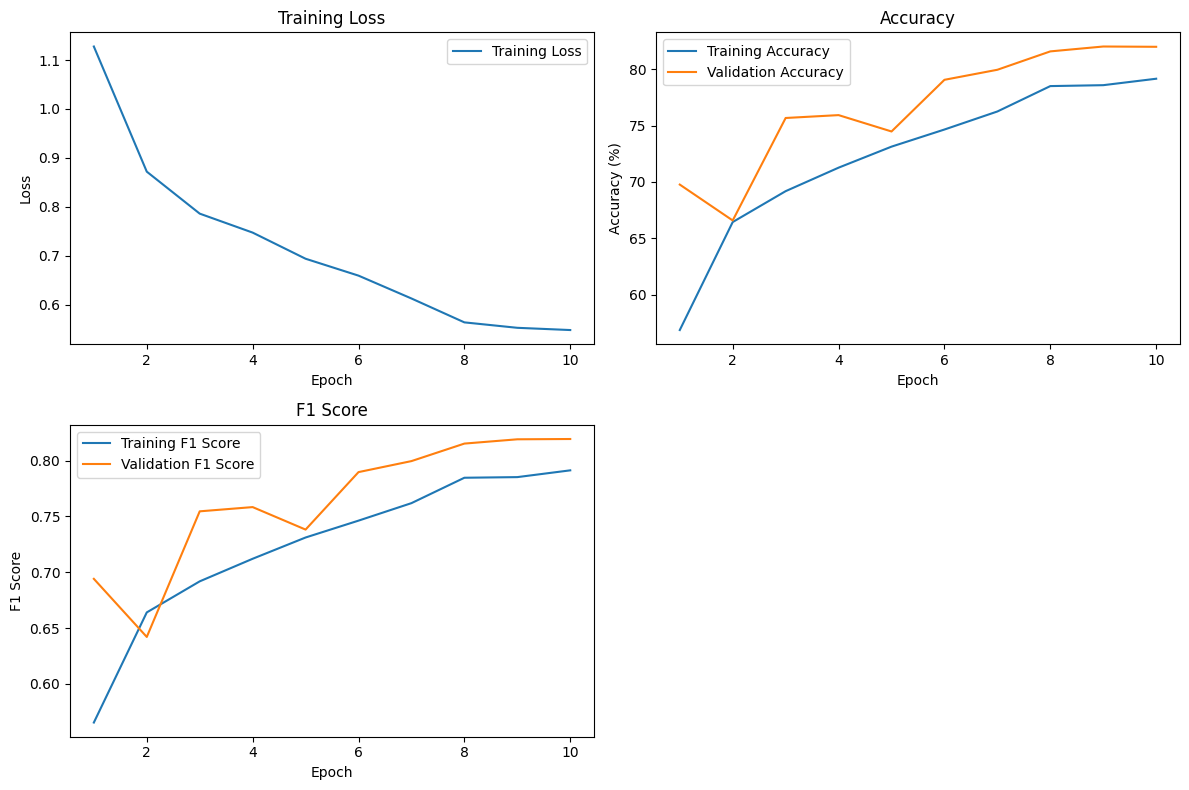

In [18]:
# Plotting
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(results_df['Epoch'], results_df['Training Loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(results_df['Epoch'], results_df['Training Accuracy'], label='Training Accuracy')
plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# F1 Score
plt.subplot(2, 2, 3)
plt.plot(results_df['Epoch'], results_df['Training F1 Score'], label='Training F1 Score')
plt.plot(results_df['Epoch'], results_df['Validation F1 Score'], label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()